## 강의 Review

In [ ]:
# 각 모델의 특징과 차이점 잘 알아두기 !! 어떤 문제점이 있는지.

# ALBERT의 사이즈를 줄이는 핵심 방법
# 1. Factorized Embedding Parameterization
# 2. Cross-layer Parameter Sharing

# ELECTRA의 핵심 방법
# Discriminator 를 사용해 Replaced Token Detection (RTD)라는 새로운 Pre-training 태스크를 제안

# BART의 핵심 방법
# noise를 원복시키는게 핵심.
# BART의 노이즈들 어떤 방법론을 가지는지 잘 생각

# T5
# Prefix를 하면 어떤 효과?

## 실습

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import os
root_dir = "/content/drive/MyDrive/자연어처리/12-2. Pretrained LM2"
sys.path.append(root_dir)

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 91.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.8 MB/s eta 0:00:00


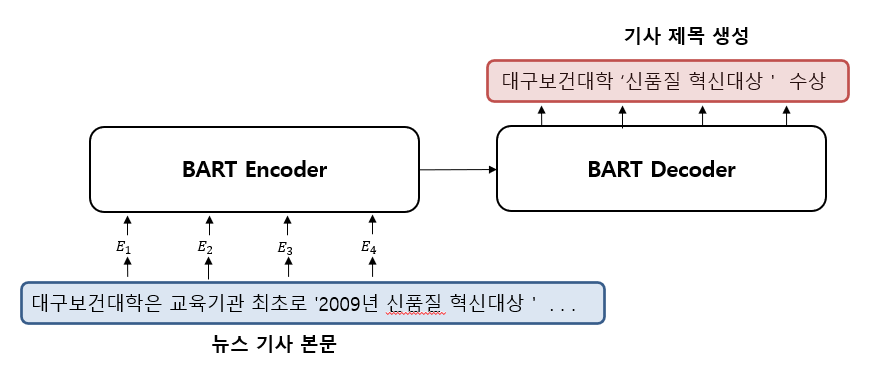

In [ ]:
from IPython.display import Image
Image(os.path.join(root_dir, "TitleGeneration.PNG"))

Train할때 몇 종류의 입력이 필요할까?
- 본문 입력
- 디코더의 입력 (시작에 s 토큰 )
- 디코더의 출력 (마지막에 /s 토큰)

활용할때는
- 인코더의 입력
- 스타트 심볼 s 한개

Vocab이 20000개면 출력의 차원은 20000

**Title Generation : BART를 이용한 뉴스기사 제목 생성기**
- Encoder, Decoder 형태이므로 번역, chatbot 등의 task 수행 가능
- 입력은 s로 시작 토큰이 존재하고, 출력은 마지막에 /s 토큰이 존재한다.
- attention_mask : encoder 1개, decoder 1개


In [ ]:
import logging

import os
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader, RandomSampler
from transformers import AdamW
import random
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

def read_data(file_path):
    datas = []
    with open(file_path, "r", encoding="utf8") as infile:
        for line in infile:
          # 입력 데이터를 \t을 기준으로 분리
          pieces = line.strip().split("\t")
          article, title = pieces[0], pieces[1]
          datas.append((article, title))


    return datas


def convert_data2feature(datas, max_length, max_dec_length, tokenizer):
    input_ids_features, attention_mask_features, decoder_input_features, decoder_attention_mask_features, label_features = [], [], [], [], []

    for article, title in tqdm(datas, desc="convert_data2feature"):
        # tokenizer를 사용하여 입력 문장을 word piece 단위로 분리
        tokenized_article = tokenizer.tokenize(article) # row_text를 token단위로 분리
        tokenized_title= tokenizer.tokenize(title) # row_text를 token단위로 분리

        input_ids = tokenizer.convert_tokens_to_ids(tokenized_article)  # word piece들을 대응하는 index로 치환
        attention_mask = [1] * len(input_ids)   # padding을 제외한 실제 데이터 정보를 반영해주기 위한 attention mask

        # 각 문장을 구분하기 위한 정보를 반영해주기 위한 token type
        decoder_input = tokenizer.convert_tokens_to_ids(['<s>']+tokenized_title) # decoder 아랫부분
        decoder_attention_mask = [1] * len(decoder_input)
        label = tokenizer.convert_tokens_to_ids(tokenized_title + ['</s>']) # decoder 윗부분

        # padding 생성
        padding = [tokenizer.convert_tokens_to_ids(tokenizer.pad_token)] * (max_length - len(input_ids))
        input_ids += padding
        attention_mask += padding

        padding = [tokenizer.convert_tokens_to_ids(tokenizer.pad_token)]* (max_dec_length - len(decoder_input))
        decoder_input += padding
        decoder_attention_mask += padding
        label += padding


        # 변환한 데이터를 각 리스트에 저장
        input_ids_features.append(input_ids[:max_length])
        attention_mask_features.append(attention_mask[:max_length])
        decoder_input_features.append(decoder_input[:max_dec_length])
        decoder_attention_mask_features.append(decoder_attention_mask[:max_dec_length]) # 여기 max_dec_length아니엿나
        label_features.append(label[:max_dec_length])

    # 변환한 데이터를 Tensor 객체에 담아 반환
    input_ids_features = torch.tensor(input_ids_features, dtype=torch.long)
    attention_mask_features = torch.tensor(attention_mask_features, dtype=torch.long)
    decoder_input_features = torch.tensor(decoder_input_features, dtype=torch.long)
    decoder_attention_mask_features = torch.tensor(decoder_attention_mask_features, dtype=torch.long)
    label_features = torch.tensor(label_features, dtype=torch.long)

    return input_ids_features, attention_mask_features, decoder_input_features, decoder_attention_mask_features, label_features

def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [ ]:
logger = logging.getLogger(__name__)
from torch.utils.data import (DataLoader, TensorDataset, RandomSampler, SequentialSampler)
from transformers import BartForConditionalGeneration
from transformers import PreTrainedTokenizerFast
def train(config):
    tokenizer = PreTrainedTokenizerFast.from_pretrained(config["pretrained_model_name_or_path"])
    model = BartForConditionalGeneration.from_pretrained(config["pretrained_model_name_or_path"]).cuda() # 별도의 모델 설계 없이 라이브러리 호출을 통해 모델 객체 생성
    """ Train the model """
    # 학습 및 평가 데이터 읽기
    train_datas = read_data(config["train_data_path"])
    test_datas = read_data(config["test_data_path"])

    # 입력 데이터 전처리
    train_input_ids_features, train_attention_mask_features, train_decoder_input_features, train_decoder_attention_mask_features, train_label_features = \
        convert_data2feature(train_datas, config["max_length"],config["max_dec_length"], tokenizer)
    test_input_ids_features, test_attention_mask_features, test_decoder_input_features, test_decoder_attention_mask_features, test_label_features = \
        convert_data2feature(test_datas, config["max_length"], config["max_dec_length"], tokenizer)

    # 학습 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    train_features = TensorDataset(train_input_ids_features, train_attention_mask_features, train_decoder_input_features, train_decoder_attention_mask_features, train_label_features)
    train_dataloader = DataLoader(train_features, sampler=RandomSampler(train_features),
                                  batch_size=config["batch_size"])

    # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    test_features = TensorDataset(test_input_ids_features, test_attention_mask_features, test_decoder_input_features, test_decoder_attention_mask_features, test_label_features)
    test_dataloader = DataLoader(test_features, sampler=SequentialSampler(test_features),
                                 batch_size=config["batch_size"])

    # 모델 학습을 위한 optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
    global_step = 1

    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()

    set_seed(config["seed"])

    ## 여기서부터 핵심 !!
    for epoch in range(config["epoch"]):
        for step, batch in enumerate(train_dataloader):
            # Skip past any already trained steps if resuming training
            model.train()
            batch = tuple(t.cuda() for t in batch)
            outputs = model(input_ids=batch[0], # encoder input
                              attention_mask=batch[1], # encoder input attention mask
                              decoder_input_ids=batch[2], # decoder input
                              decoder_attention_mask=batch[3], # decoder input attention mask
                              labels=batch[4], # decoder output = label (title + /s)
                                return_dict=True)

            loss = outputs["loss"]

            loss.backward()
            if (global_step+1) % 50 == 0:
                print("{} Processed.. Total Loss : {}".format(global_step+1, loss.item()))

            tr_loss += loss.item() # 텐서에서 스칼라 값을 추출하는 방법

            optimizer.step()
            model.zero_grad()
            global_step += 1

            # Save model checkpoint
            if global_step % 500 == 0:
                evaluate(config, model, tokenizer, test_dataloader)

                output_dir = os.path.join(config["output_dir_path"], "checkpoint-{}".format(global_step))
                print("Model Save in {}".format(output_dir))
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)

                # Take care of distributed/parallel training
                model_to_save = model.module if hasattr(model, "module") else model
                model_to_save.save_pretrained(output_dir)

    return global_step, tr_loss / global_step

def evaluate(config, model, tokenizer, test_dataloader):
    model.eval()
    for batch in tqdm(test_dataloader):
        batch = tuple(t.cuda() for t in batch)

        # generate : 생성을 위한 별도의 함수 제공
        dec_outputs = model.generate(input_ids = batch[0],
                                     attention_mask=batch[1],
                                     max_length=config["max_dec_length"],
                                     eos_token_id=1, # </s> 가 1이라고 알려줌.  1이 나오면 멈춰라 !
                                     do_sample=False, # greedy_search할 것인지 sampling 할 것인지의 여부 -> False면 greedy, True이면 beam search
                                     bad_words_ids=[[5]] # 나쁜말 생성 금지 !
                                    )

        batch_size = batch[0].size()[0]

        dec_outputs = dec_outputs.tolist() # prediction
        dec_labels = batch[4].tolist() # label

        ### 토큰으로 출력된 prediction 값을 문장 형태로 변환하는 코드
        ################### 여기 코드 수정 ############################
        for index in range(batch_size):
            # 기존 코드
            # if 1 in dec_outputs[index]:
            #     dec_outputs[index] = dec_outputs[index]
            # if -100 in dec_labels[index]:
            #     dec_labels[index] = dec_labels[index][:dec_labels[index].index(-100)]
            # pred = "".join(tokenizer.convert_ids_to_tokens(dec_outputs[index][1:])).replace("Ġ", " ").replace("<pad>", "").replace("</s>", "").replace("▁", " ")
            # ref = "".join(tokenizer.convert_ids_to_tokens(dec_labels[index][:-1])).replace("Ġ", " ").replace("<pad>", "").replace("</s>", "").replace("▁", " ")

            # 수정 코드
            if tokenizer.eos_token_id in dec_outputs[index][1:]:
                dec_outputs[index] = dec_outputs[index][:dec_outputs[index][1:].index(tokenizer.eos_token_id)+1]  # 처음부터 EOS까지 끊기(decoder output 0번째 인덱스에 1이 존재하므로 이후부터 확인)
            if tokenizer.eos_token_id in dec_labels[index]:
                dec_labels[index] = dec_labels[index][:dec_labels[index].index(tokenizer.eos_token_id)]    # 처음부터 EOS까지 끊기

            pred = "".join(tokenizer.convert_ids_to_tokens(dec_outputs[index][1:])).replace("Ġ", " ").replace("▁", " ")
            ref = "".join(tokenizer.convert_ids_to_tokens(dec_labels[index][:])).replace("Ġ", " ").replace("▁", " ")

            print("REFERENCE : {}\nDECODED   : {}\n".format(ref, pred))


기존 코드의 문제점 : dec_outputs[index] = dec_outputs[index] 는 아무런 변화도 일어나지 않는 코드이다.  
또한 -100은 존재하지 않기 때문에 if -100 in dec_labels[index] 문은 실행되지 않는다.    
따라서 기존 코드에서의 두 개의 if문은 아무런 의미가 없는 코드이다.  
따라서 dec_outputs 과 dec_labels를 EOS부분까지 끊어주는 코드를 추가해주었다.  
또한 EOS까지 끊었으므로 pred와 ref 변수에서 기존에 pad토큰과 eos토큰을 replace하는 코드를 제거해주었다.  

In [ ]:

if (__name__ == "__main__"):
    save_dir = os.path.join(root_dir, "save")
    output_dir = os.path.join(root_dir, "output")
    cache_dir = os.path.join(root_dir, "cache")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)

    set_seed(seed=1234)

    config = {"mode": "train",
              "train_data_path": os.path.join(root_dir, "train.txt"),
              "test_data_path": os.path.join(root_dir, "test.txt"),
              "output_dir_path": output_dir,
              "save_dir_path": save_dir,
              "cache_dir_path": cache_dir,
              "pretrained_model_name_or_path": "hyunwoongko/kobart",
              "max_length": 250,
              "max_dec_length": 60,
              "epoch": 1,
              "batch_size": 16,
              "seed": 42,
              }

    if (config["mode"] == "train"):
        train(config)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


convert_data2feature: 100%|██████████| 14/14 [00:00<00:00, 720.67it/s]


50 Processed.. Total Loss : 0.9186775088310242
100 Processed.. Total Loss : 0.5788224935531616
150 Processed.. Total Loss : 0.6327047944068909
200 Processed.. Total Loss : 0.6392269134521484
250 Processed.. Total Loss : 0.6245847940444946
300 Processed.. Total Loss : 0.7172134518623352
350 Processed.. Total Loss : 0.5184640884399414
400 Processed.. Total Loss : 0.5023883581161499
450 Processed.. Total Loss : 0.5937961935997009
500 Processed.. Total Loss : 0.6928255558013916


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

REFERENCE :  한스킨, 직장인 대상 ‘미생(美<unk>)’ 페이스북 이벤트 실시
DECODED   :  한스킨, 페이스북 이벤트 실시

REFERENCE :  부산 도심 녹지광장 만든다
DECODED   :  부산 도심 광화문광장 조성

REFERENCE :  경제부/5. 11/2010 대한민국영어교육박람회 14일 개막..
DECODED   :  2010 대한민국영어교육박람회 14일부터 3일간 엑스코서 개최

REFERENCE :  “국정화 반대 시국선언 교사 징계”
DECODED   :  교육부, 시국선언 교사들 파악...중징계 요구

REFERENCE :  미세먼지 걱정없는 필리핀의 고급 주거단지
DECODED   :  포스코건설, 필리핀 클락 클락힐즈

REFERENCE :  한반도 상공 신호정보, 2020년까지 분석 시도
DECODED   :  신호정보 수집 분석, 2020년까지 구축

REFERENCE :  로얄앤컴퍼니, 장애인용 안전손잡이
DECODED   :  로얄앤컴퍼니, 노약자·장애인용 안전손잡이 8종 출시

REFERENCE :  과도한 온도상승 전기찜질기 등 리콜 조치
DECODED   :  전기찜질기 4개, 전기카펫 2개 등 14개 제품 결함

REFERENCE :  임상수 감독과 마틴 스콜세지 ‘만남’
DECODED   :  임상수 감독, 마틴 스콜세지와 만남 “난 당신의 팬”

REFERENCE :  화요시조창작교실 운영
DECODED   :  대구시조시인협회, 시조창작교실 운영

REFERENCE :  주담대 금리 일제히 인상...변동형 상품 최고 4.6%
DECODED   :  변동형 주택담보대출 금리 18일부터 일제히 인상

REFERENCE :  CJ오쇼핑, 농촌 봉사활동 실시
DECODED   :  CJ오쇼핑, 배 재배농가 현명농장서 농촌 봉사활동 실시

REFERENCE :  채은정, 몽환&관능 매력 물씬
DECODED   :  채은정, 몽환적인 화보 공개...‘키니야 놀자’

REFERENCE :  설비투자 증가에

550 Processed.. Total Loss : 0.5967217087745667
600 Processed.. Total Loss : 0.5876702070236206
650 Processed.. Total Loss : 0.5401512980461121
700 Processed.. Total Loss : 0.5875812768936157
750 Processed.. Total Loss : 0.6535248160362244
800 Processed.. Total Loss : 0.52138751745224
850 Processed.. Total Loss : 0.5179714560508728
900 Processed.. Total Loss : 0.4551239609718323
950 Processed.. Total Loss : 0.5576562881469727
